## IMPORTING MODULES

In [ ]:
import numpy as np
import pandas as pd
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

## READING DATASET

source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/news-authenticity-classifier'

In [ ]:

true_data = pd.read_csv(path+"/True.csv")
fake_data = pd.read_csv(path+"/Fake.csv")

true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

data = pd.concat([true_data,fake_data])
data.sample(frac=1,random_state=42)

print(data.shape)
data.head()

(44898, 5)


,title,text,subject,date,Target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [ ]:
data['Target'] = data['Target'].map({'True':1,'Fake':0})


In [ ]:
data.head()

,title,text,subject,date,Target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
(data['Target'].sum()/len(data))*100

47.70145663503943

In [ ]:

x_train,x_test,y_train,y_test = train_test_split(data['title'], data['Target'],random_state=42, test_size=0.3)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,random_state=42,test_size=0.5)

## BERT INITIALISATION

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Text(0, 0.5, 'Number of texts')

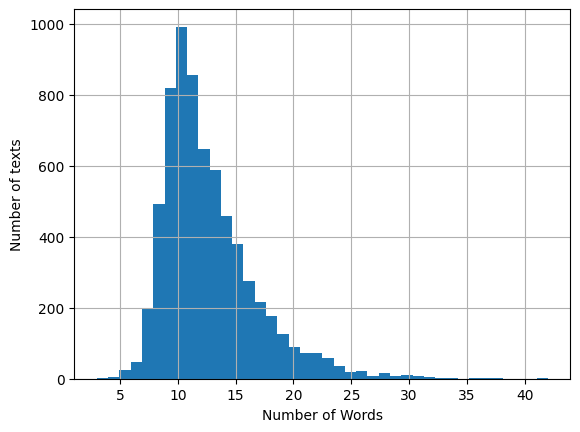

In [ ]:
seq_len = [len(title.split()) for title in x_test]

pd.Series(seq_len).hist(bins = 40)
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:

mx = 15
tokens_train = tokenizer.batch_encode_plus(
    x_train.tolist(),
    max_length = mx,
    padding='max_length',
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    x_val.tolist(),
    max_length = mx,
    padding='max_length',
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    x_test.tolist(),
    max_length = mx,
    padding='max_length',
    truncation=True
)

In [ ]:

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

In [ ]:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


In [ ]:
for param in bert.parameters():
    param.requires_grad = False

# MODEL DEFINITION

In [ ]:
class Classifier(nn.Module):
    def __init__(self, bert):
      super().__init__()
      self.bert = bert
      self.seq=nn.Sequential(
          nn.Linear(768,512),
          nn.ReLU(),
          nn.Dropout(0.1),
          nn.Linear(512,2),
          nn.LogSoftmax(dim=1)
      )
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.seq(cls_hs)
      return x

model = Classifier(bert)
from transformers import AdamW
optimizer = torch.optim.AdamW(model.parameters(),lr = 1e-5)
cross_entropy  = nn.NLLLoss()

# MODEL TRAINING

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                #
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)

  return avg_loss


In [ ]:
def evaluate():
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

In [ ]:

best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]
epochs=2
for epoch in range(epochs):
    print('\n Epoch {:}'.format(epoch + 1))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.562
Validation Loss: 0.479

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of

# MODEL EVALUATION

In [ ]:
path = 'model_weights.pt'
model.load_state_dict(torch.load(path))

<ipython-input-19-6b3af14c9799>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      3473
           1       0.77      0.92      0.83      3262

    accuracy                           0.82      6735
   macro avg       0.83      0.83      0.82      6735
weighted avg       0.84      0.82      0.82      6735

